# Time Series Event Detection

This notebook was created to be shown at FH in Graz during a lecture on time series event detection. Even though a full running example can be found in main.py, this notebook explains the workflow in greater detail. 

It is running on Python 3.8.5 with dependencies listed in the requirements.txt file.

In [5]:
%load_ext autoreload

%autoreload 2

In [6]:
#Set devices_id
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]=""

import logging

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger()

logger.info("Loading packages...")

2023-01-30 13:52:18,797 | INFO : Loading packages...


In [25]:
from config import get_config
from models.model import model_factory
from datasets.data import data_factory_fun
from utils.datagen import UnetGen
from datasets import event as evt

import pandas as pds
import numpy as np


conf = get_config("")
conf.update(spacecraft='Wind')

usage: ipykernel_launcher.py [-h] [--spacecraft SPACECRAFT] [--split SPLIT]
                             [--resampling RESAMPLING] [--feature FEATURE]
                             [--stride STRIDE] [--test_stride TEST_STRIDE]
                             [--sampling_rate SAMPLING_RATE]
                             [--catalog {helcat,nguyen,allcat}]
                             [--shift SHIFT] [--std_features STD_FEATURES]
                             [--remove_features REMOVE_FEATURES]
                             [--data_dir DATA_DIR] [--output_dir OUTPUT_DIR]
                             [--GPU GPU] [--experiment_name EXPERIMENT_NAME]
                             [--task {seq2seq}] [--epochs EPOCHS]
                             [--optimizer {Adam,RAdam}]
                             [--batch_size BATCH_SIZE] [--max_lr MAX_LR]
                             [--base_lr BASE_LR] [--step_size STEP_SIZE]
                             [--schedule {warmup,cyclic}] [--lr LR]
                   

SystemExit: 2

/home/hruedisser/arcanenv/lib64/python3.8/site-packages/IPython/core/interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Data Preprocessing

In [ ]:
data = data_factory_fun(conf)

[autoreload of config failed: Traceback (most recent call last):
  File "/home/hruedisser/arcanenv/lib64/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/hruedisser/arcanenv/lib64/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib64/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib64/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/hruedisser/arcane-icmes/config.py", line 23


AttributeError: 'NoneType' object has no attribute 'resample'

In [6]:
data.all_df

,bx,by,bz,bt,vt,np,tp,beta,Pdyn,texrat
2007-01-01 00:00:00,1.223244,-3.684057,0.080246,3.888975,331.939625,14.843064,19413.118748,0.646101,2.735598e-09,0.720593
2007-01-01 00:10:00,0.951300,-4.066096,0.060271,4.184126,330.122928,14.243541,18994.705795,0.536584,2.596340e-09,0.720648
2007-01-01 00:20:00,0.325078,-2.837958,0.867163,3.237512,328.747382,13.780732,25637.551120,1.314895,2.491679e-09,0.989950
2007-01-01 00:30:00,0.472819,-3.130698,2.199837,3.867082,327.870816,11.593735,24086.478532,0.654117,2.083827e-09,0.939926
2007-01-01 00:40:00,-0.159123,-1.394647,1.394927,2.462851,329.516427,12.122023,28034.909930,2.919348,2.202596e-09,1.073363
...,...,...,...,...,...,...,...,...,...,...
2021-04-28 23:10:00,-0.941782,1.187671,0.184250,1.526914,368.055969,4.161323,12093.222967,0.748976,9.428810e-10,0.303752
2021-04-28 23:20:00,-0.941784,1.187670,0.184250,1.526914,368.055969,4.161323,12093.222967,0.748976,9.428810e-10,0.303752
2021-04-28 23:30:00,-0.941785,1.187669,0.184249,1.526914,368.055969,4.161323,12093.222967,0.748976,9.428810e-10,0.303752
2021-04-28 23:40:00,-0.941786,1.187668,0.184248,1.526914,368.055969,4.161323,12093.222967,0.748976,9.428810e-10,0.303752


In [7]:
data.X_test

,Pdyn,beta,bt,bx,by,bz,np,texrat,tp,vt
2007-01-01 00:00:00,0.733165,-0.076034,-0.428195,0.406938,-1.064839,0.052577,1.652052,-0.088519,-0.819134,-0.861950
2007-01-01 00:10:00,0.634073,-0.103581,-0.313126,0.319958,-1.172525,0.045369,1.533749,-0.088511,-0.824326,-0.880919
2007-01-01 00:20:00,0.559600,0.092189,-0.682178,0.119663,-0.826348,0.336545,1.442423,-0.050420,-0.741898,-0.895282
2007-01-01 00:30:00,0.269385,-0.074018,-0.436731,0.166918,-0.908863,0.817456,1.010865,-0.057496,-0.761144,-0.904435
2007-01-01 00:40:00,0.353897,0.495760,-0.984191,-0.035206,-0.419520,0.526995,1.115112,-0.038622,-0.712150,-0.887252
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 23:10:00,1.229051,-0.058319,1.170730,-0.507401,1.638582,-1.625263,1.568542,0.105362,0.069788,-0.389676
2017-12-31 23:20:00,1.225145,-0.061805,1.274651,-0.792835,1.665936,-1.135231,1.479930,0.095837,0.092351,-0.328865
2017-12-31 23:30:00,1.323483,-0.021639,1.033298,0.195071,-0.702654,-2.510284,1.579648,0.116548,0.180013,-0.320608
2017-12-31 23:40:00,1.348712,-0.013306,1.044984,0.241594,-1.013934,-1.315120,1.577222,0.117398,0.212301,-0.300084


In [9]:
data.evtlist

In [10]:
for i in range (4):
    print(str(data.evtlist[i])) # each event is stored in a list with "begin" and "end"

2021-04-24 22:30:00 ---> 2021-04-25 22:46:00
2021-04-15 03:16:00 ---> 2021-04-15 13:12:00
2021-04-04 21:52:00 ---> 2021-04-06 10:02:00
2021-03-26 18:00:00 ---> 2021-03-27 19:02:00


/home/hruedisser/arcanenv/lib64/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/hruedisser/arcanenv/lib64/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/hruedisser/arcanenv/lib64/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


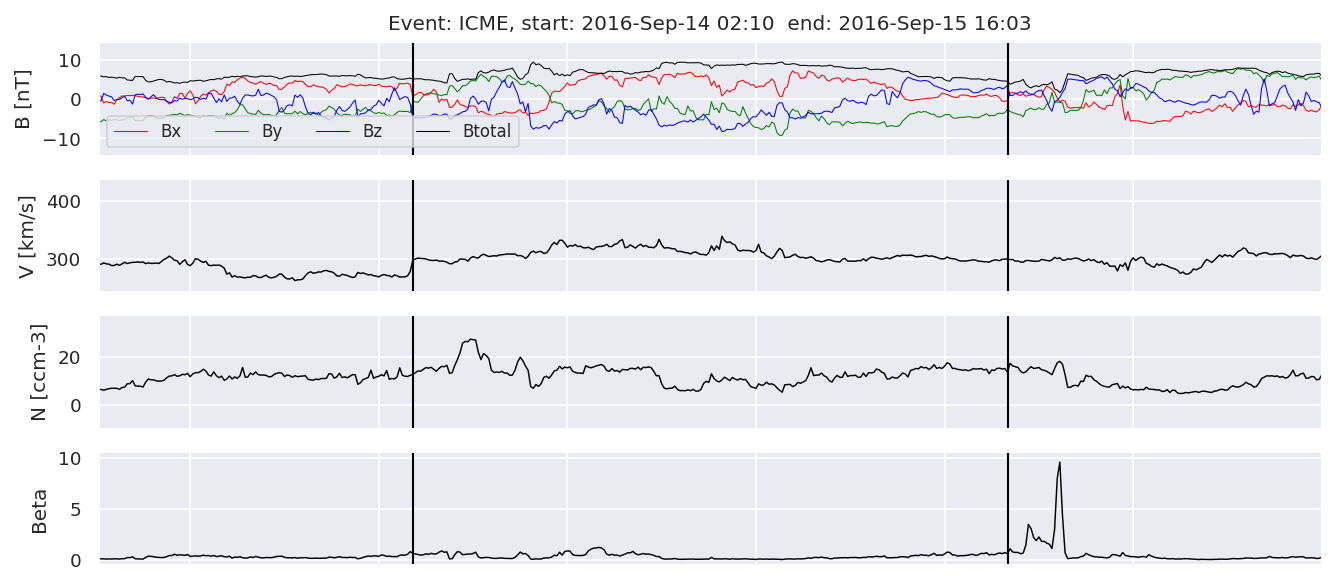

In [11]:
data.evtlist[42].iwfplotnopred(data.all_df, 20, 'Event: ')

In [8]:
data.labels_df

,ICME
2007-01-01 00:00:00,0.0
2007-01-01 00:10:00,0.0
2007-01-01 00:20:00,0.0
2007-01-01 00:30:00,0.0
2007-01-01 00:40:00,0.0
...,...
2021-04-28 23:10:00,0.0
2021-04-28 23:20:00,0.0
2021-04-28 23:30:00,0.0
2021-04-28 23:40:00,0.0


### Model and Data Generator

In [12]:
model, callbacks = model_factory(conf, data)

2023-01-27 12:47:33,327 | INFO : Feature dimension equals 10
2023-01-27 12:47:33,328 | INFO : Sequence length equals 1024
2023-01-27 12:47:33,329 | INFO : Image size equals (1024, 1, 10)
2023-01-27 12:47:33,329 | INFO : Choosing model architecture: ResUNet
2023-01-27 12:47:33,330 | INFO : Building model for Seq2Seq
2023-01-27 12:47:55.484528: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-27 12:47:55.485040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: leo10
2023-01-27 12:47:55.485059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: leo10
2023-01-27 12:47:55.486646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2023-01-27 12:47:55.486927: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2023-01-27 12:47:55.486941:

In [16]:
model.summary()

Model: "ResUNetPlusPlusSeq2Seq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 1, 10) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 1024, 1, 64)  1984        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 1024, 1, 64)  256         conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 1024, 1, 64)  0           batch_normalization_28[0][0]     
_____________________________________________________________________________

In [13]:
callbacks

In [15]:
train_gen = UnetGen('train', conf, data)
val_gen = UnetGen('val', conf, data)

2023-01-27 12:54:36,310 | INFO : Initializing data generator for training...
2023-01-27 12:54:36,319 | INFO : Initializing data generator for validation...


In [15]:
import tensorflow as tf

model.fit(train_gen,validation_data=val_gen,epochs=conf['epochs'],callbacks=callbacks)

2023-01-27 12:55:14.887471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/400


2023-01-27 12:55:26,877 | ERROR : Internal Python error in the inspect module.
Below is the traceback from this internal error.

2023-01-27 12:55:26,906 | INFO : 
Unfortunately, your original traceback can not be constructed.

2023-01-27 12:55:26,988 | ERROR : Internal Python error in the inspect module.
Below is the traceback from this internal error.

2023-01-27 12:55:26,993 | INFO : 
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/home/hruedisser/arcanenv/lib64/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1191541/4220157523.py", line 3, in <module>
    model.fit(train_gen,validation_data=val_gen,epochs=conf['epochs'],callbacks=callbacks)
  File "/home/hruedisser/arcanenv/lib64/python3.8/site-packages/keras/engine/training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/hruedisser/arcanenv/lib64/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "/home/hruedisser/arcanenv/lib64/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 950, in _call
    return self._stateless_fn(*args, **kwds)
  File "/home/hruedisser/arcanenv/lib64/python3.8/site-packages/tensorflow/python/eager/function.py", line 3039, in __call__
    return grap

TypeError: object of type 'NoneType' has no len()

In [16]:
from utils.metrics import dice_coef, dice_loss, true_skill_score

model = tf.keras.models.load_model(conf['save_dir']+'/resunet_seq2seq_1', custom_objects = {"dice_loss": dice_loss, "dice_coef": dice_coef, "true_skill_score": true_skill_score})

ERROR! Session/line number was not unique in database. History logging moved to new session 151


In [17]:
test_gen = UnetGen('test', conf, data)

2023-01-27 12:55:53,959 | INFO : Initializing data generator for testing...
2023-01-27 12:55:53,960 | INFO : No teststride given, using window length.


In [18]:
model.evaluate(test_gen, verbose=1)

41/41 [==============================] - 58s 1s/step - loss: 0.4822 - accuracy: 0.9648 - recall: 0.6456 - precision: 0.5567 - dice_coef: 0.5115 - true_skill_score: 0.6363 - mean_io_u: 0.6961


[0.48215341567993164,
 0.9648133516311646,
 0.6456141471862793,
 0.5567209720611572,
 0.5114647150039673,
 0.6362779140472412,
 0.6960542798042297]

In [19]:
from utils import postprocess

result = postprocess.generate_result(data, model, conf)

100%|█████████████████████████████████████████| 151/151 [00:39<00:00,  3.83it/s]


In [20]:
result

,pred,true
1,,
2007-01-01 00:00:00,0.0,0.0
2007-01-01 00:10:00,0.0,0.0
2007-01-01 00:20:00,0.0,0.0
2007-01-01 00:30:00,0.0,0.0
2007-01-01 00:40:00,0.0,0.0
...,...,...
2017-12-28 02:50:00,0.0,0.0
2017-12-28 03:00:00,0.0,0.0
2017-12-28 03:10:00,0.0,0.0


In [21]:
result.index = pds.to_datetime(result.index)
resultbin = postprocess.make_binary(result['pred'], 0.5)
events = postprocess.makeEventList(resultbin, 1, 10)
ICMEs = postprocess.removeCreepy(events, 3)
test_clouds = [x for x in data.evtlist if (x.begin.year in data.test)]

/home/hruedisser/arcanenv/lib64/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/hruedisser/arcanenv/lib64/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/hruedisser/arcanenv/lib64/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


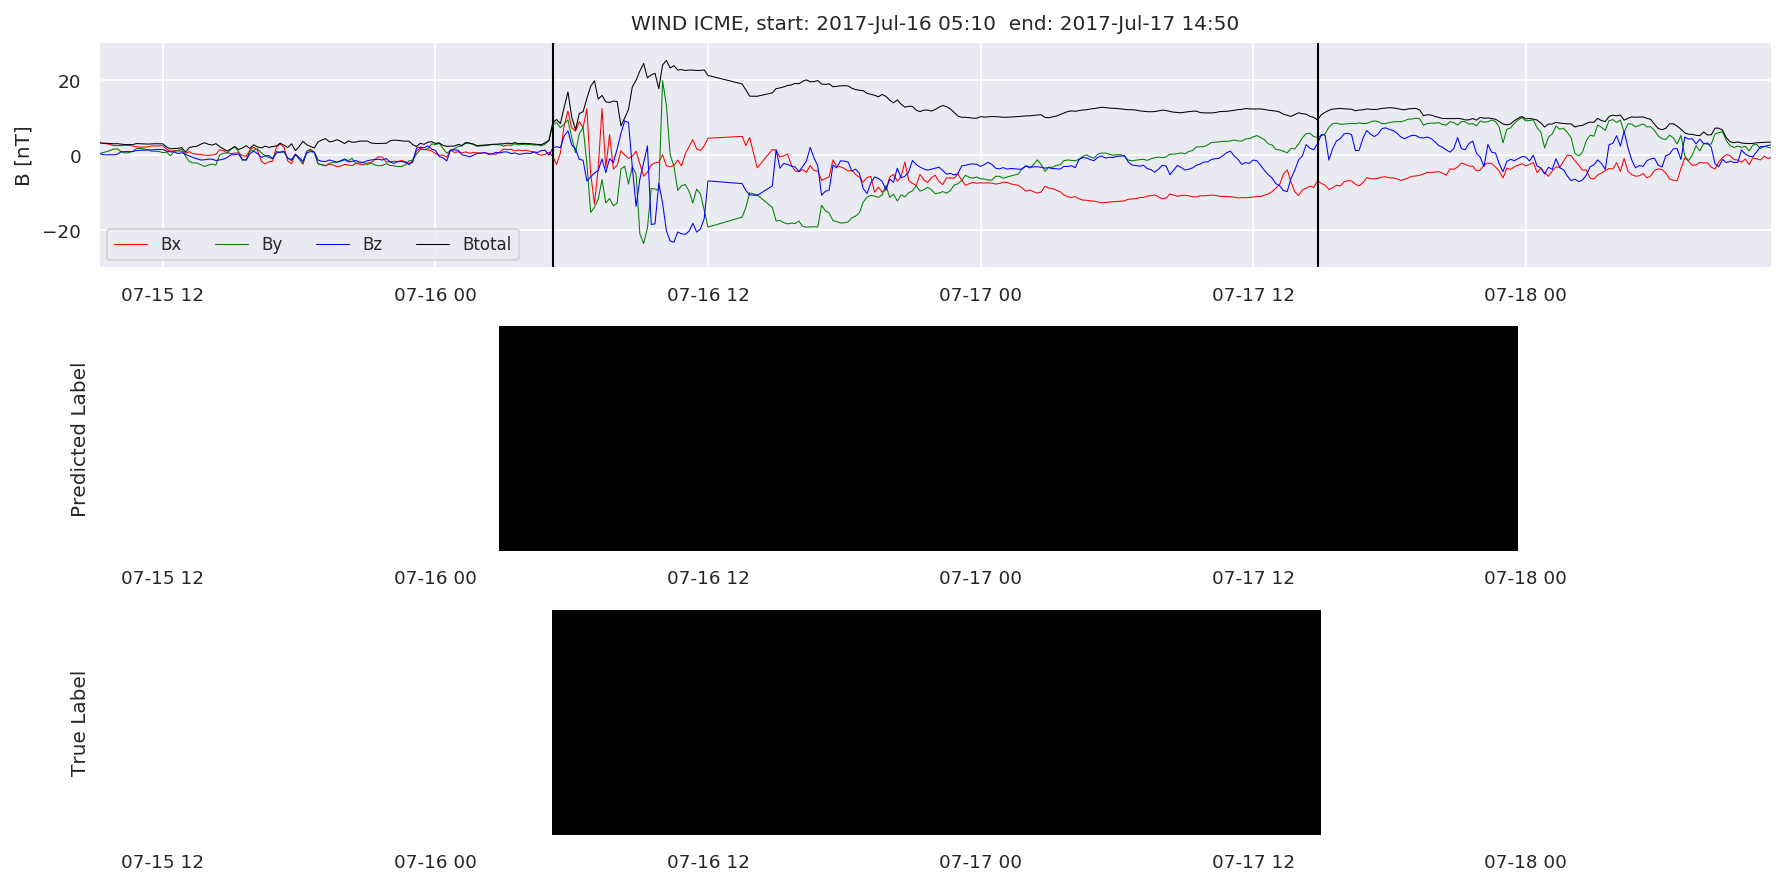

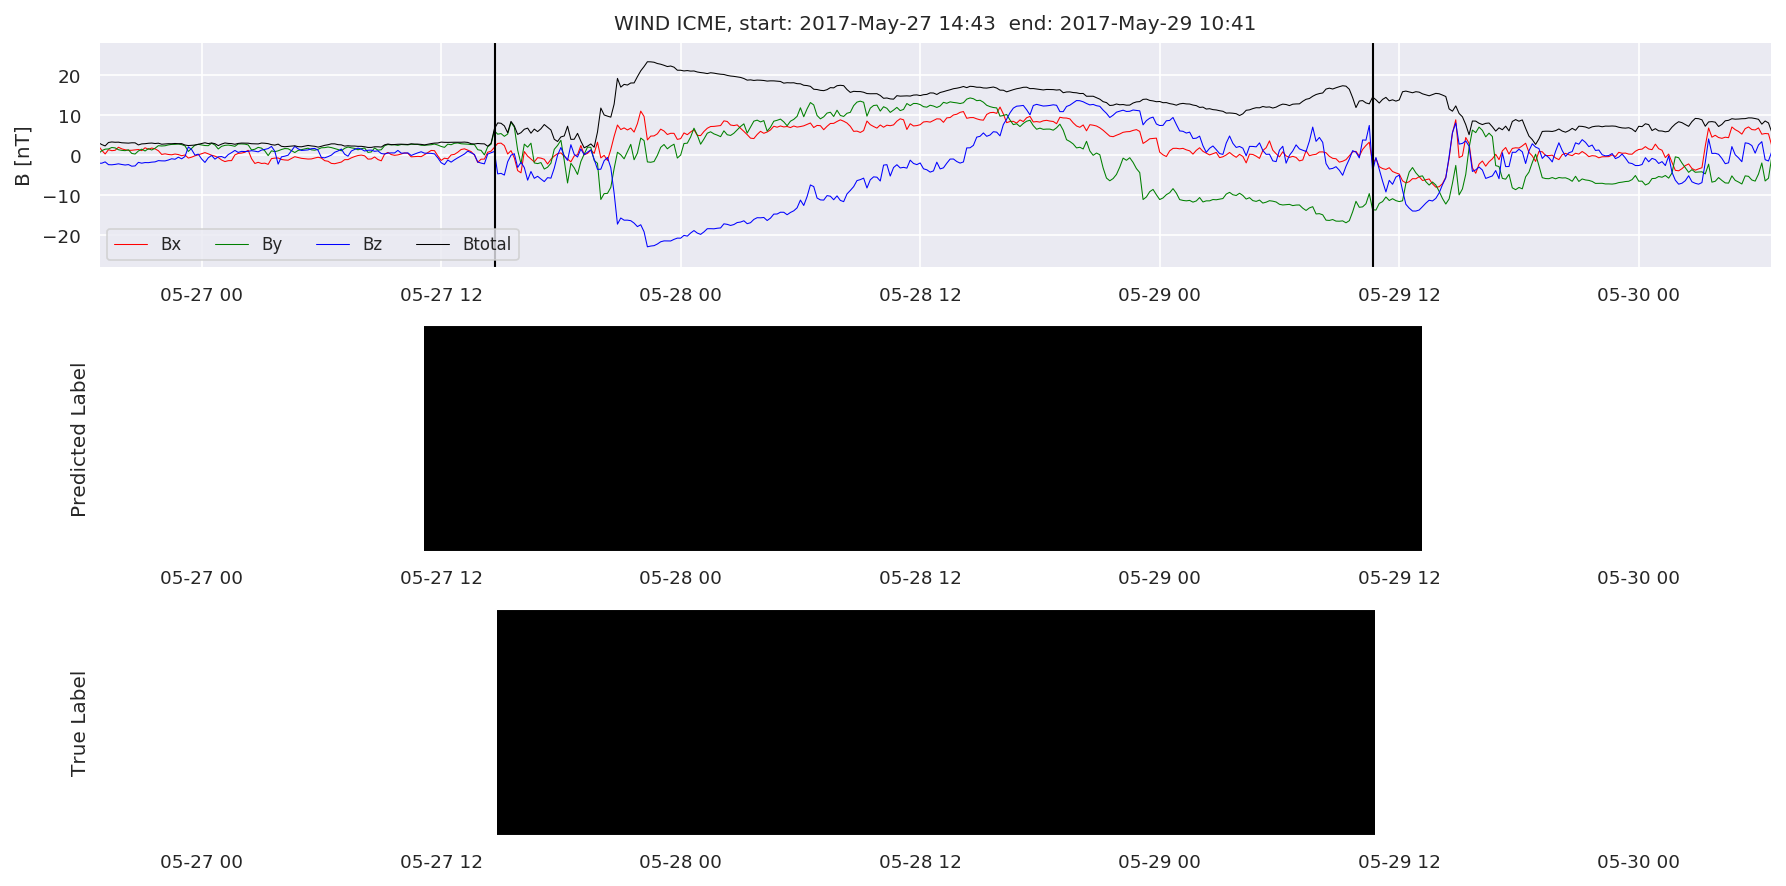

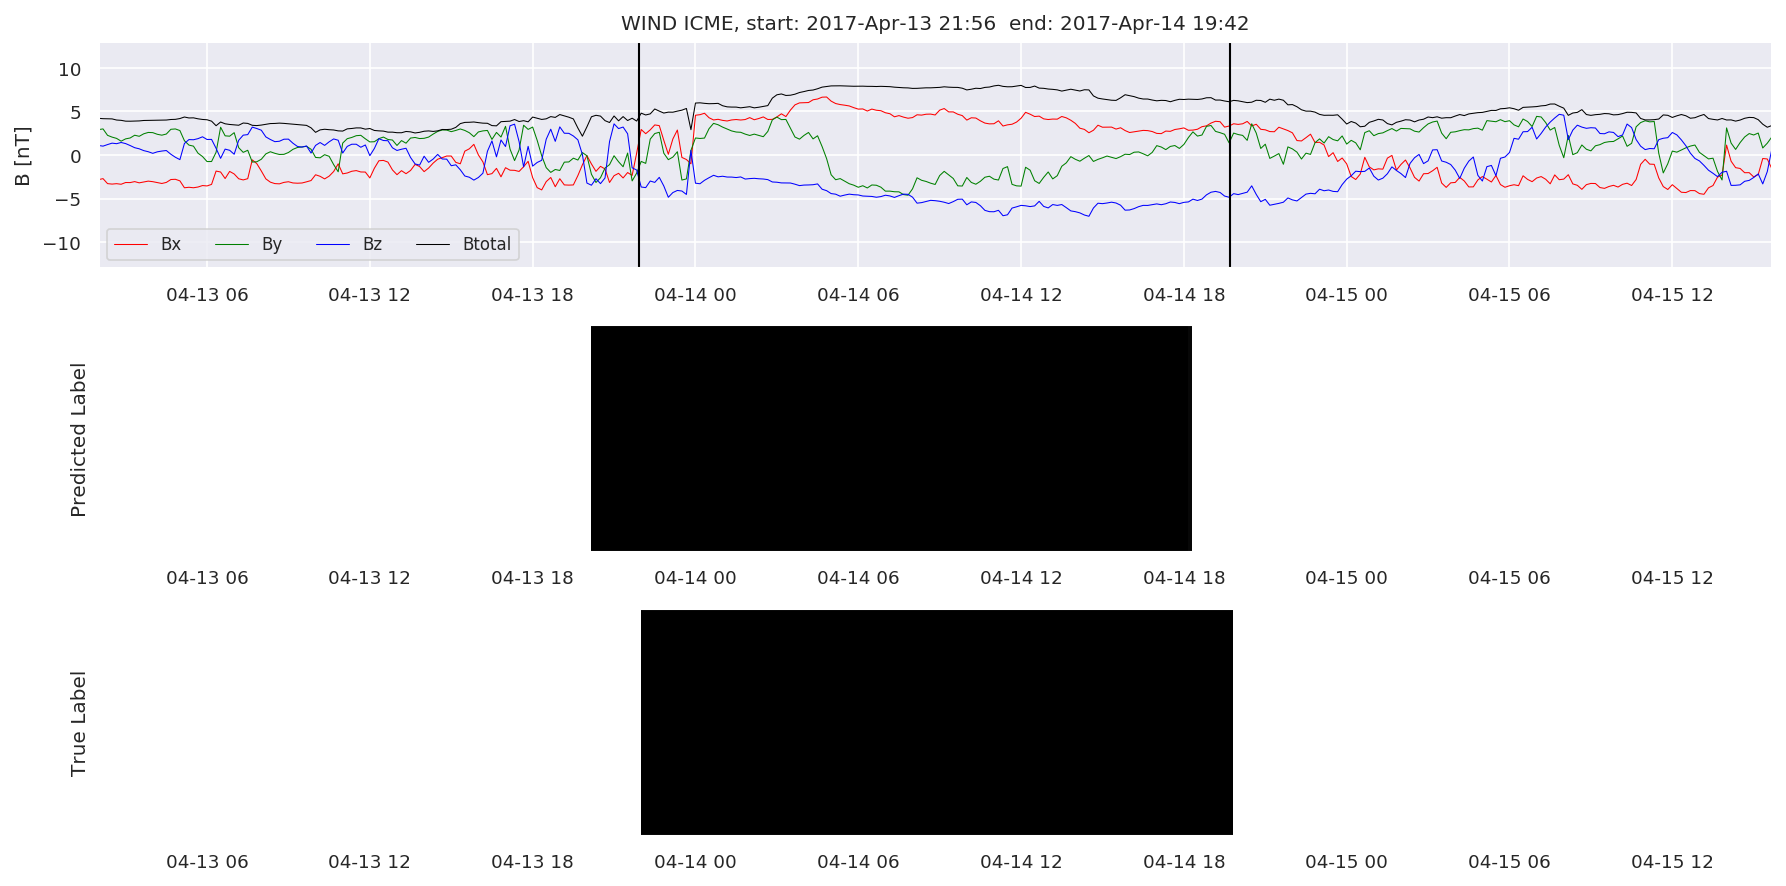

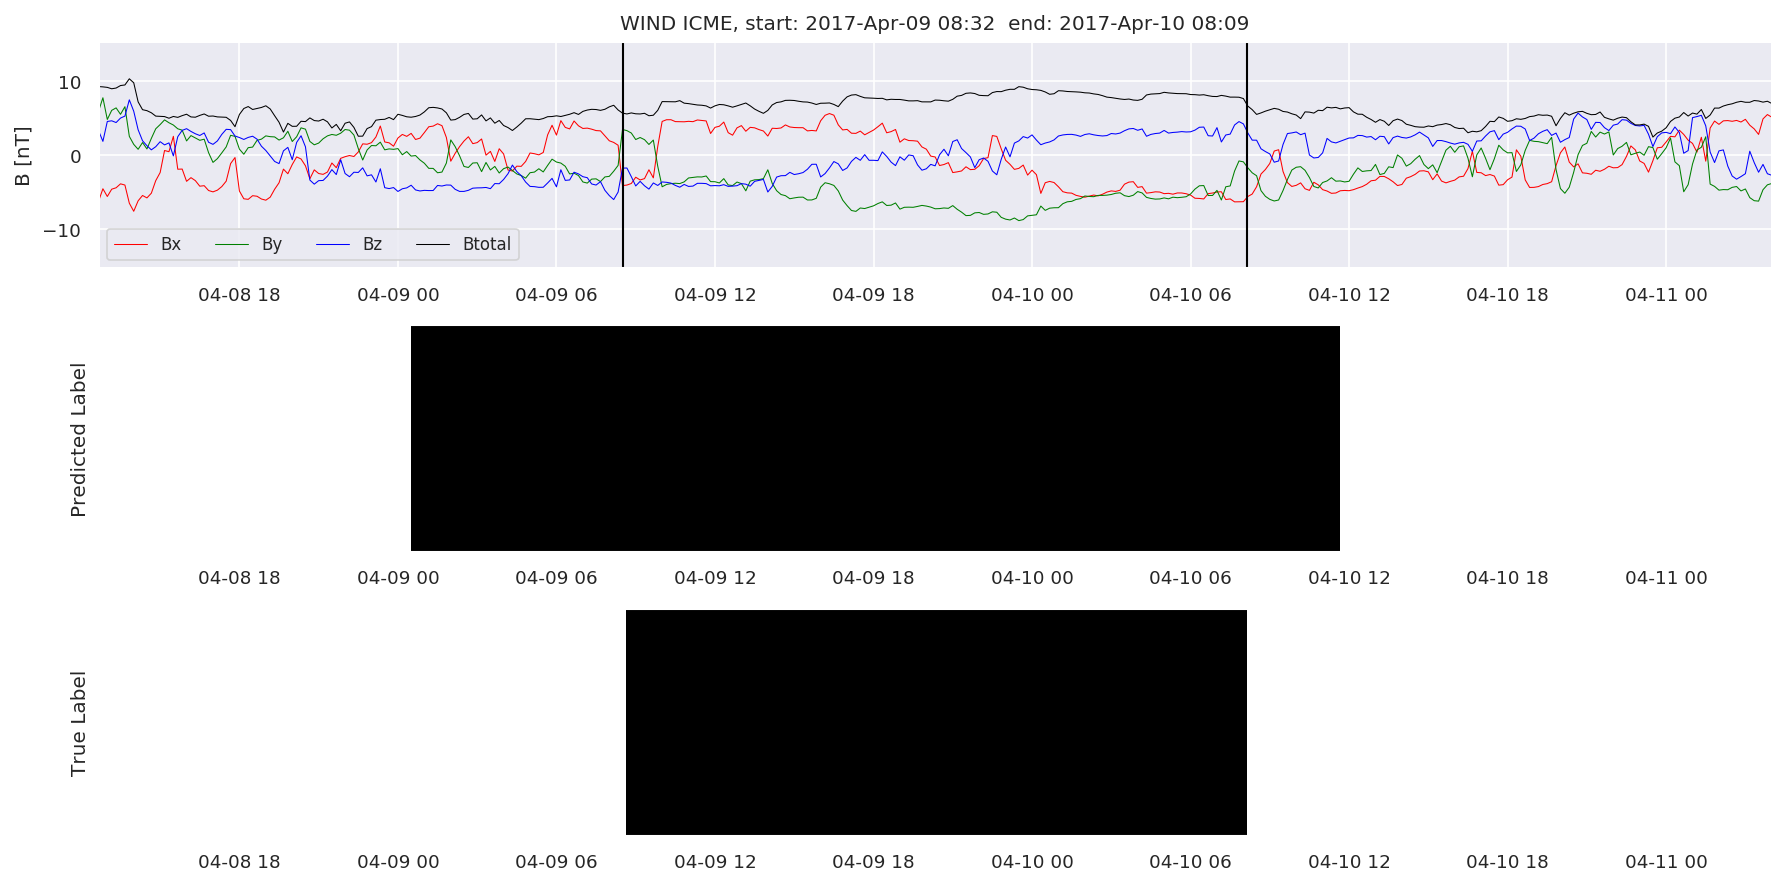

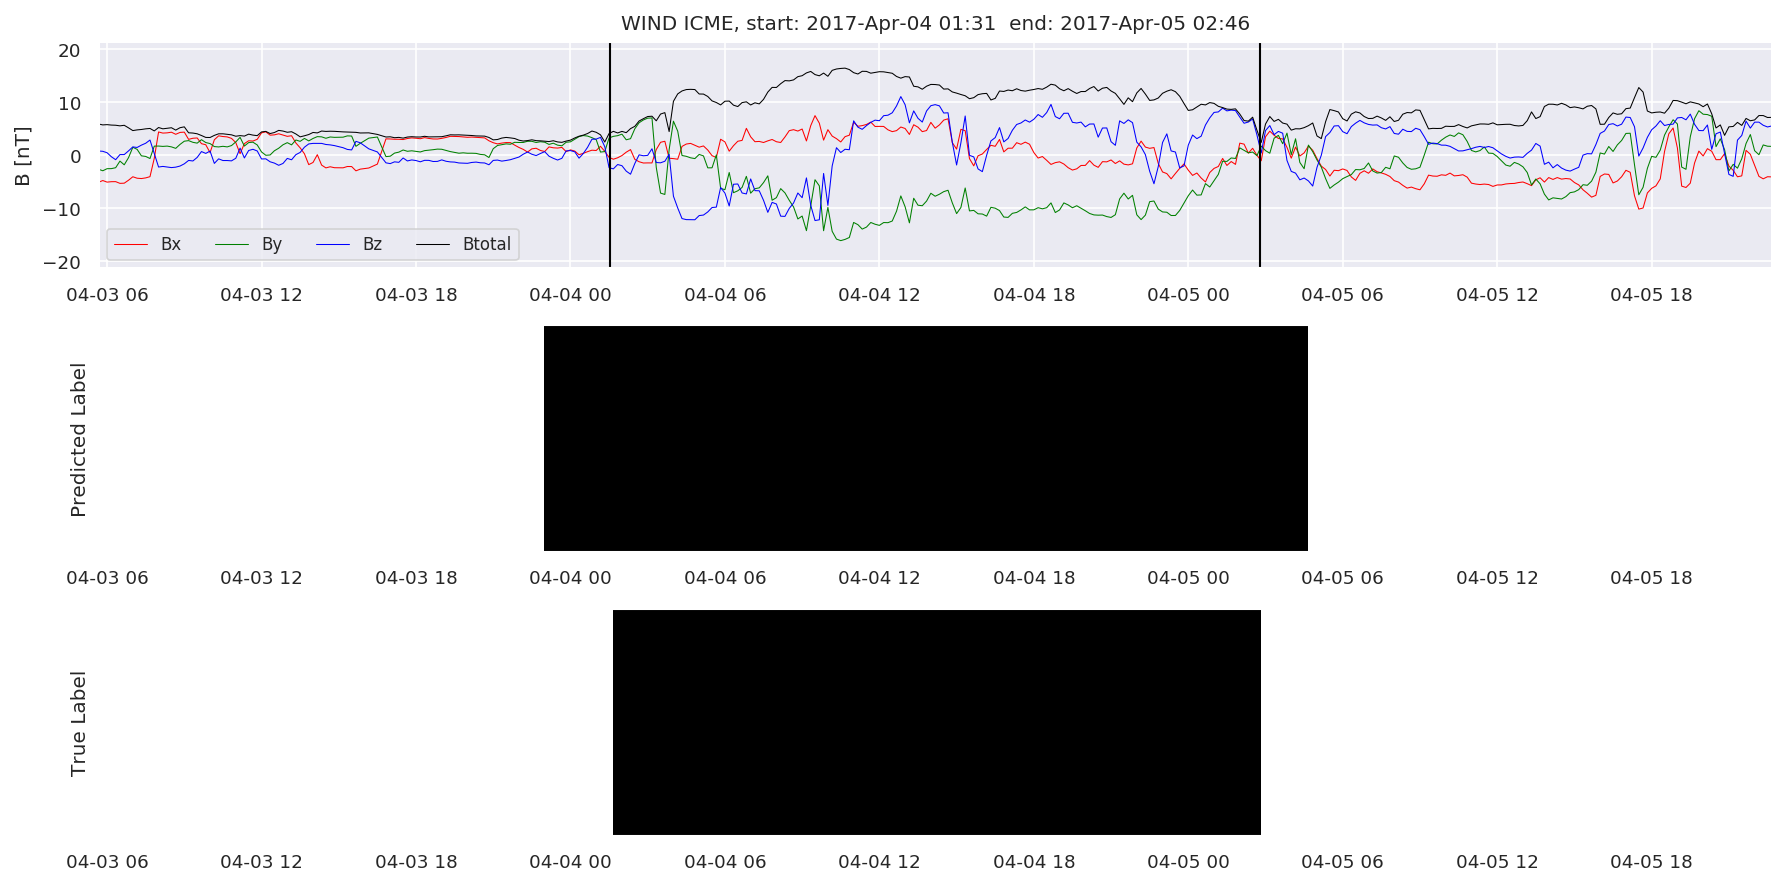

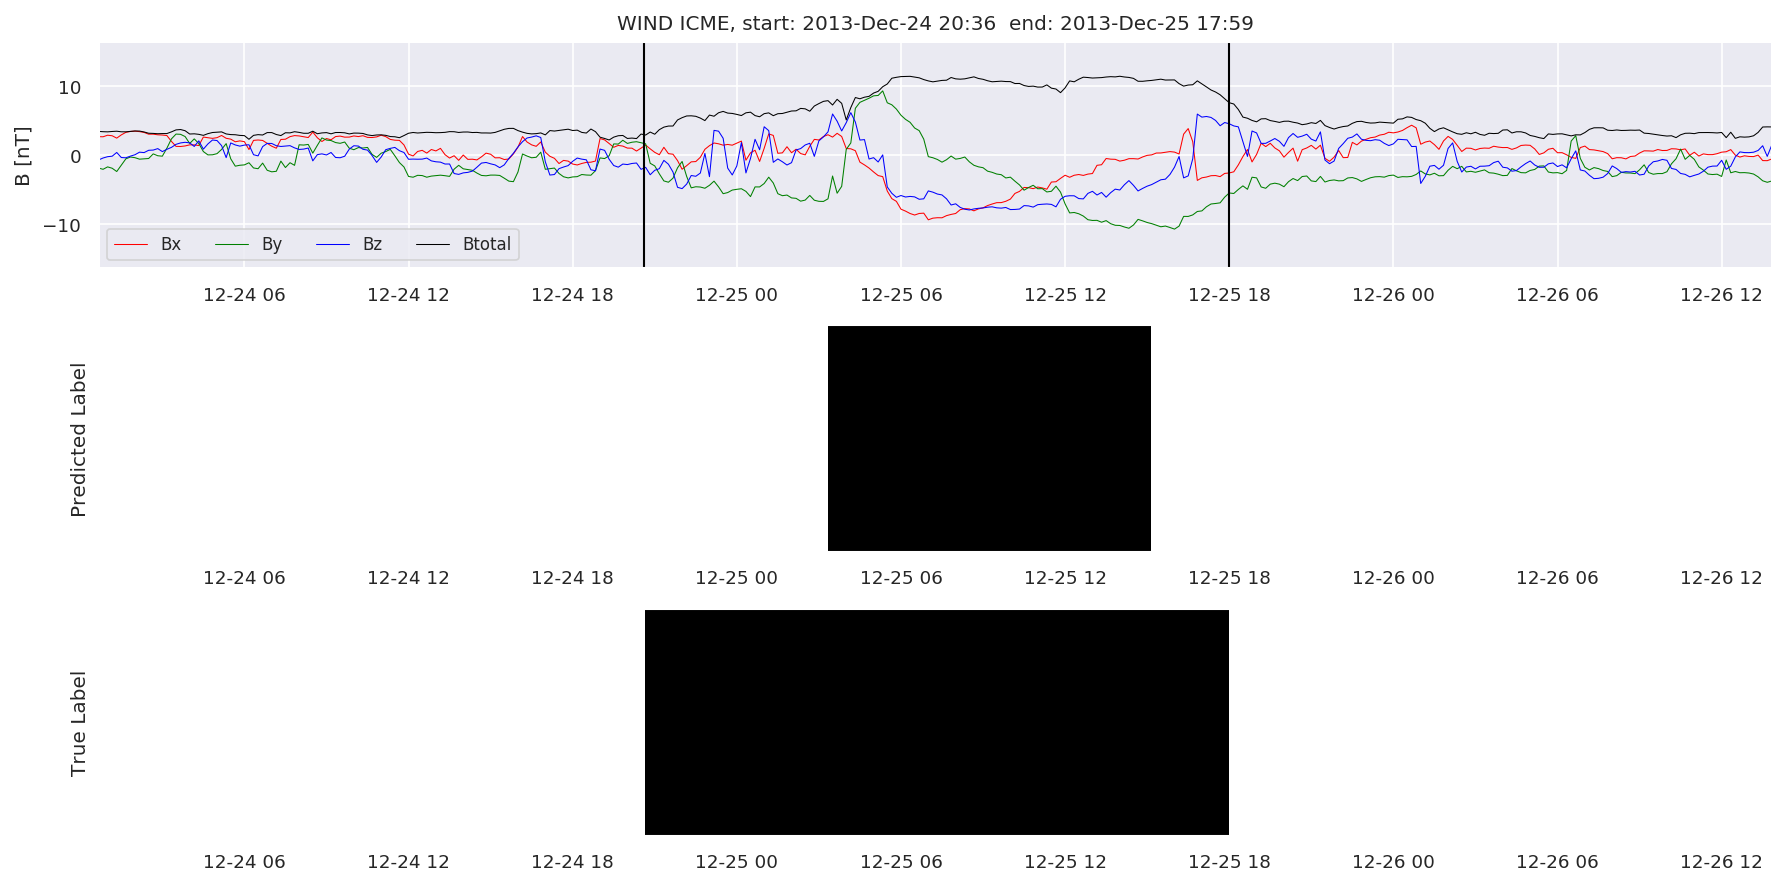

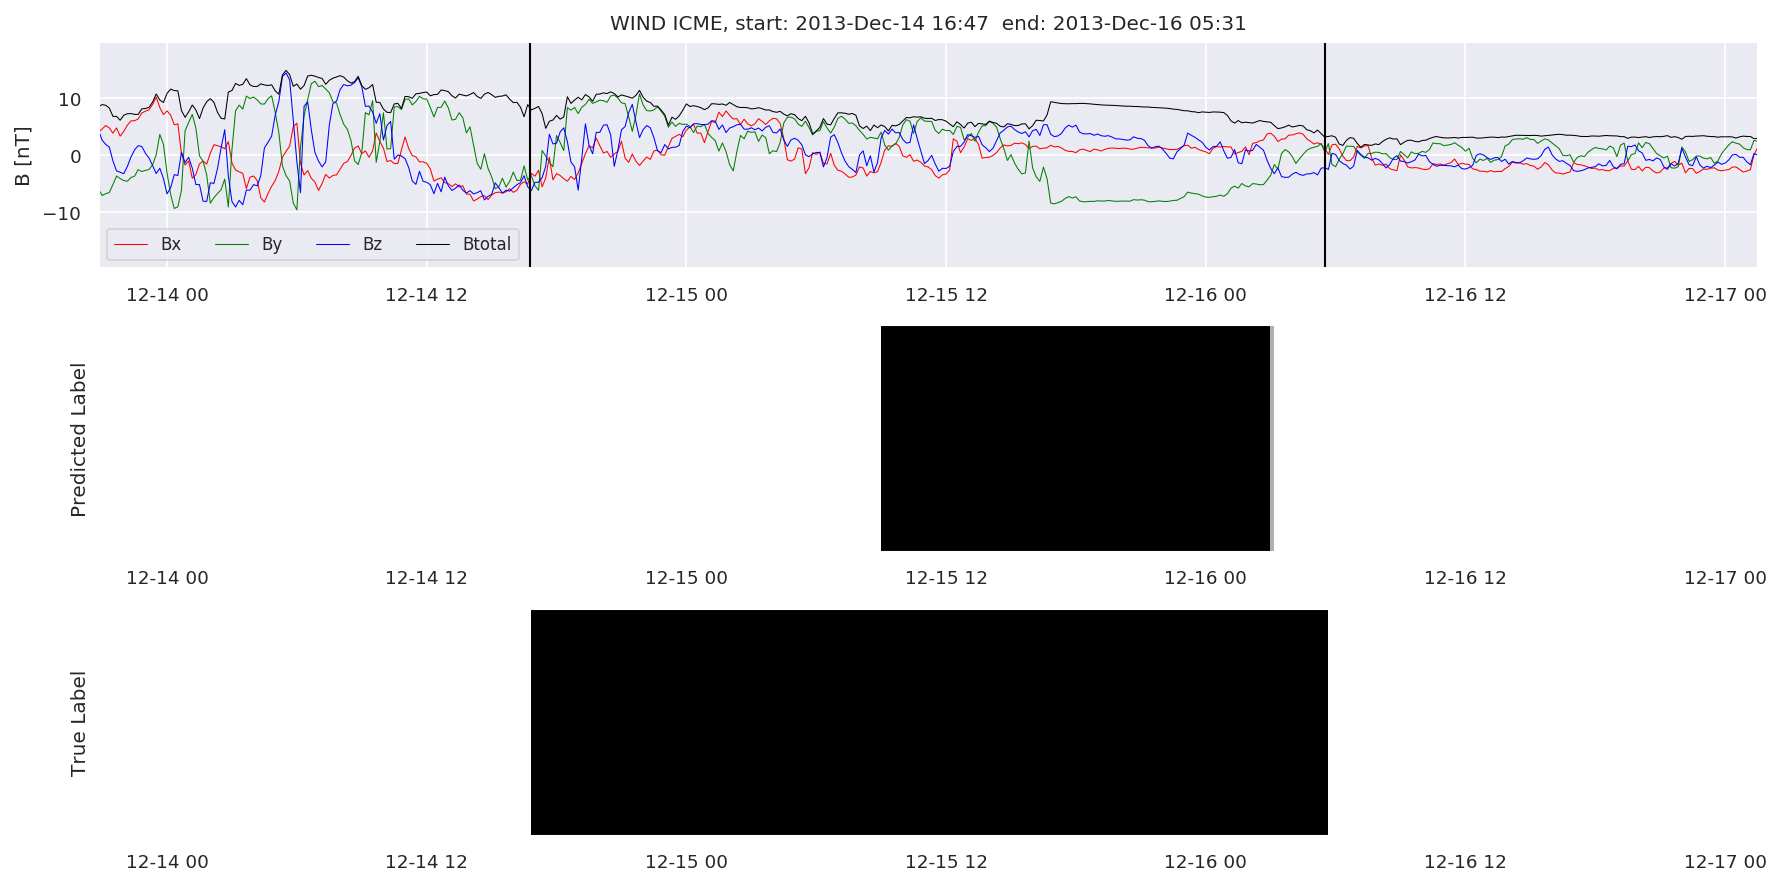

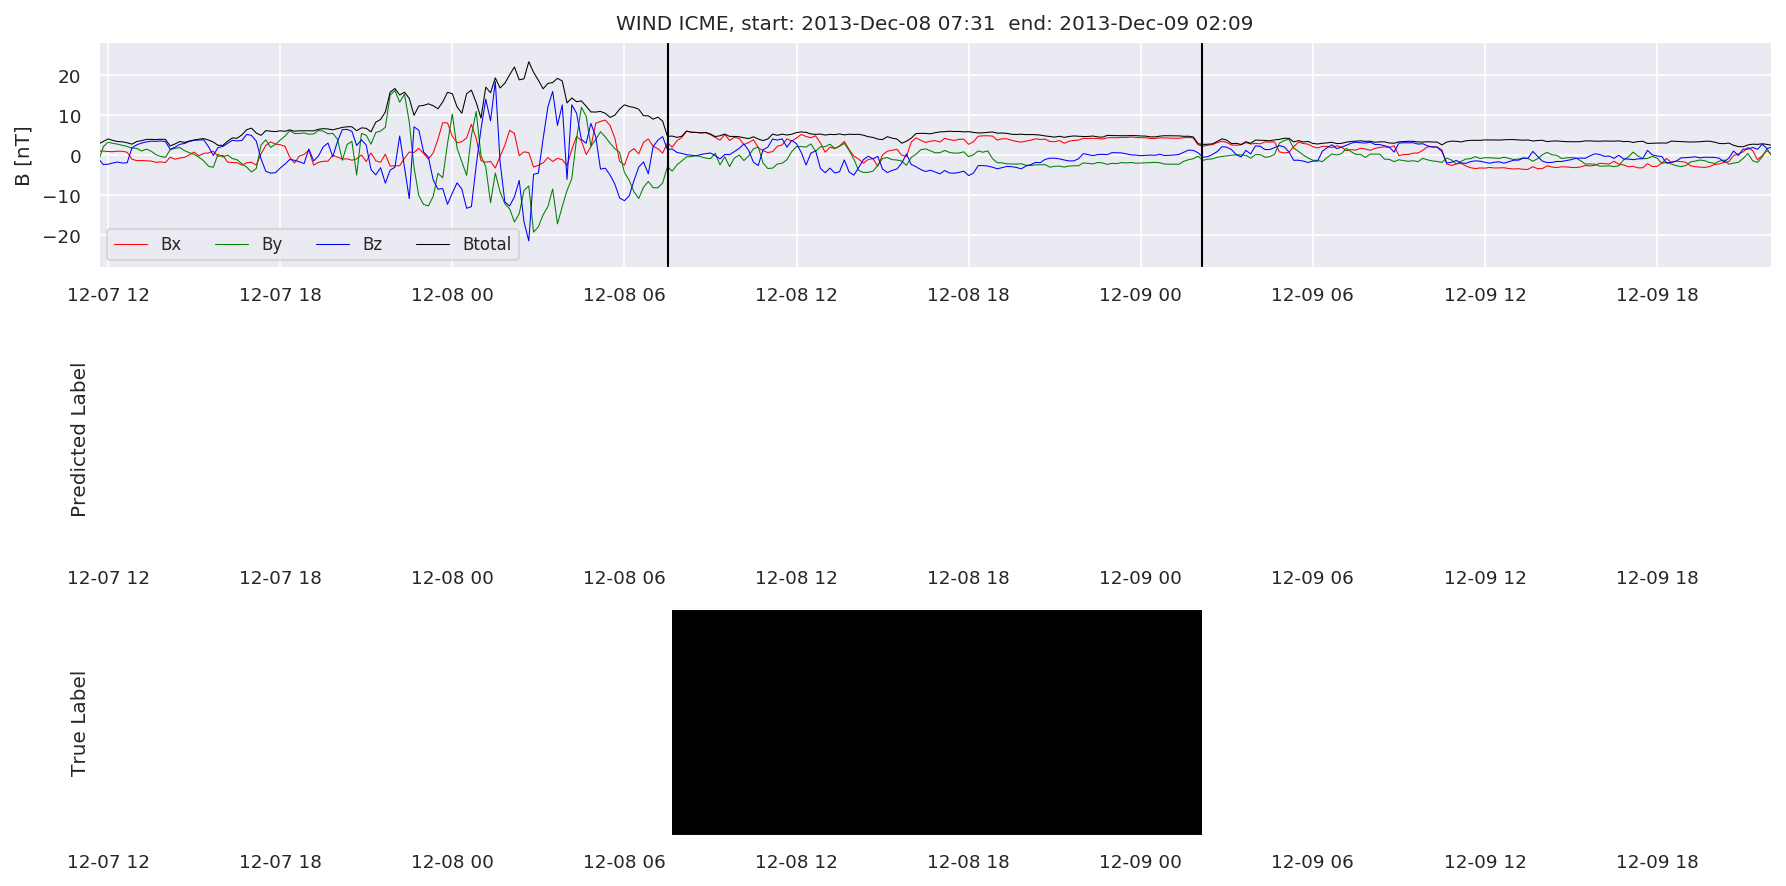

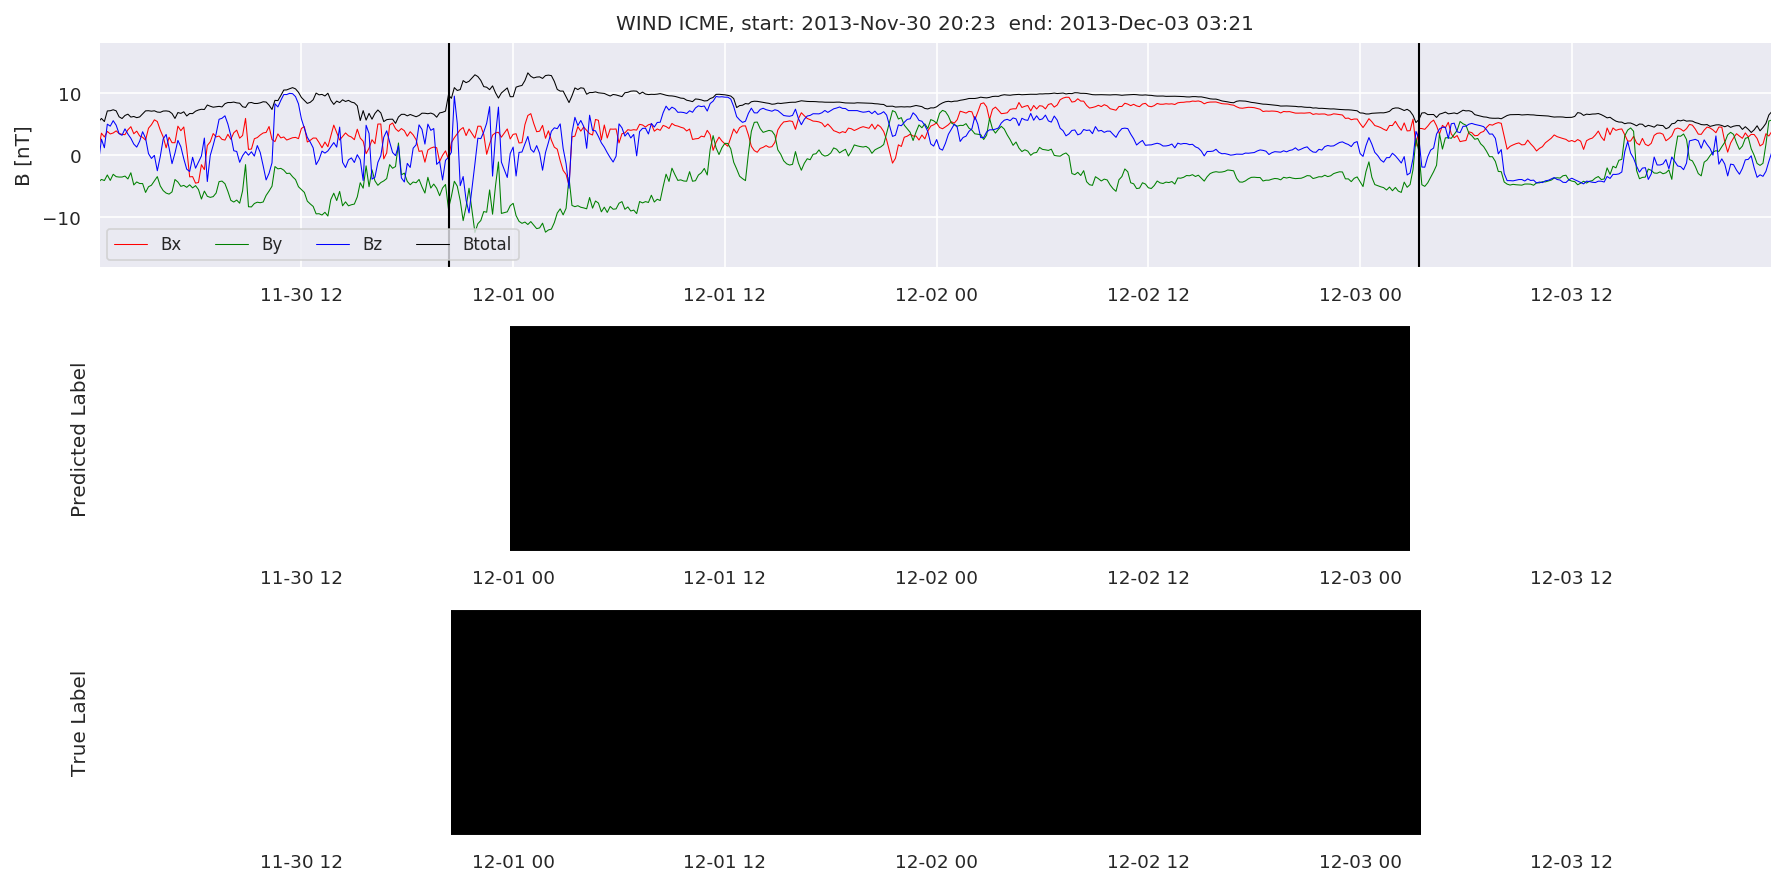

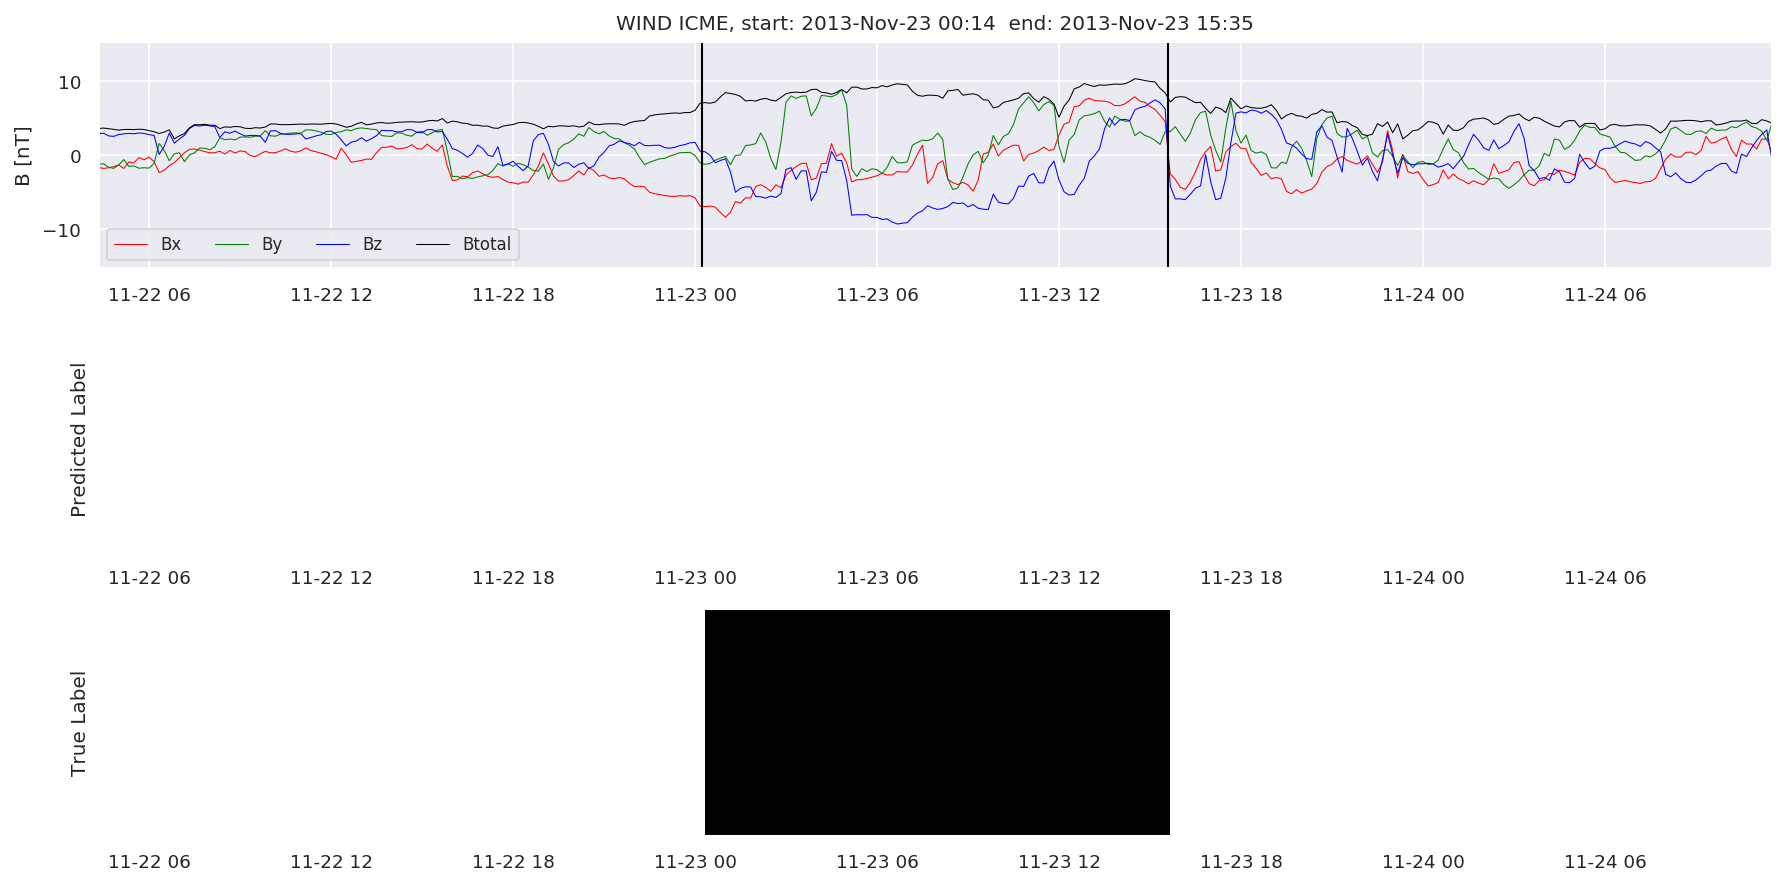

In [22]:
#Plot events and associated similarity values

for i in range(5, 15):
    test_clouds[i].plot_similaritymap(data.all_df,20,i,'WIND ',result)

In [23]:
# Score by event WIND

print('WIND:')

TP, FN, FP, detected = postprocess.evaluate(ICMEs, test_clouds, thres=0.1)
print('Precision is:',len(TP)/(len(TP)+len(FP)))
print('Recall is:',len(TP)/(len(TP)+len(FN)))
print('True Positives', len(TP))
print('False Negatives', len(FN))
print('False Positives', len(FP))

WIND:
Precision is: 0.5454545454545454
Recall is: 0.631578947368421
True Positives 24
False Negatives 14
False Positives 20
